In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, MaxPool1D, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from tab2img.converter import Tab2Img

In [3]:
# load the dataset
df_train = pd.read_csv('KDDTrain+.txt', header=None)
df_test = pd.read_csv('KDDTest+.txt', header=None)
df_train20 = pd.read_csv('KDDTrain+_20Percent.txt', header=None)

In [4]:
# check the shape of the dataset
print(df_train.shape, df_test.shape, df_train20.shape)

(125973, 43) (22544, 43) (25192, 43)


In [5]:
# add columns in the train dataset
df_train.columns = ['duration','protocol_type','service','flag','src_bytes','dst_byte','land','wrong_fragment',
                    'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
                    'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_logins',
                    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
                    'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_srv_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
        'dst_host_rerror_rate','dst_host_srv_rerror_rate','class','difficulty_level']

# add columns in the test dataset
df_test.columns = ['duration','protocol_type','service','flag','src_bytes','dst_byte','land','wrong_fragment',
                    'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
                    'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_logins',
                    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
                    'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_srv_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
        'dst_host_rerror_rate','dst_host_srv_rerror_rate','class','difficulty_level']

In [6]:
# identify the missing values
df_train.isnull().values.any(), df_test.isnull().values.any()

(False, False)

In [7]:
# select categorical variables
train_cat = df_train.select_dtypes('object')
test_cat = df_test.select_dtypes('object')

In [8]:
train_cat.head()

,protocol_type,service,flag,class
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,neptune
3,tcp,http,SF,normal
4,tcp,http,SF,normal


In [9]:
test_cat.head()

,protocol_type,service,flag,class
0,tcp,private,REJ,neptune
1,tcp,private,REJ,neptune
2,tcp,ftp_data,SF,normal
3,icmp,eco_i,SF,saint
4,tcp,telnet,RSTO,mscan


In [10]:
# list of categorical columns without the label
cols_list = ['protocol_type', 'service', 'flag']
cols_list

['protocol_type', 'service', 'flag']

In [11]:
# one-hot encoding function
def one_hot_encode(data, col):
  for i in col:
    dummies = pd.get_dummies(data[i], prefix=i, drop_first=False, dtype='int')
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(columns=[i])
  return data

In [12]:
#perform one hot encoding for training set
df_train_onehot = one_hot_encode(df_train, cols_list)

In [13]:
#perform one hot encoding for test set
df_test_onehot = one_hot_encode(df_test, cols_list)

In [14]:
df_train_onehot.shape, df_test_onehot.shape

((125973, 124), (22544, 118))

In [53]:
#check if they are the same
are_equal = df_train_onehot.equals(df_test_onehot)
are_equal

False

In [64]:
#df_concat = pd.concat([df_train_onehot, df_test_onehot], ignore_index=True)
#print(df_concat)
#df_concat.isnull().values.any()

col = set(df_train_onehot.columns).intersection(set(df_test_onehot.columns))
len(col)

118

In [65]:
set(df_train_onehot.columns).difference(set(df_test_onehot.columns))

{'service_aol',
 'service_harvest',
 'service_http_2784',
 'service_http_8001',
 'service_red_i',
 'service_urh_i'}

In [67]:
df_train_onehot.columns.values

array(['duration', 'src_bytes', 'dst_byte', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in',
       'num_compromised', 'root_shell', 'su_attempted', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'is_host_logins', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_srv_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class',
       'difficulty_level', 'protocol_type_icmp', 'protocol_type_tcp',
       'protocol_type_udp', 'service_IRC', 'service_X11',
       'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp',
       'service_

In [73]:
test_col = df_test_onehot.columns.values
df_train_new = df_train_onehot[test_col]
df_train_new.shape

(125973, 118)

In [74]:
#df_train_onehot['class']
df_train_new['class']

0          normal
1          normal
2         neptune
3          normal
4          normal
           ...   
125968    neptune
125969     normal
125970     normal
125971    neptune
125972     normal
Name: class, Length: 125973, dtype: object

In [75]:
df_test_onehot['class']

0        neptune
1        neptune
2         normal
3          saint
4          mscan
          ...   
22539     normal
22540     normal
22541       back
22542     normal
22543      mscan
Name: class, Length: 22544, dtype: object

In [76]:
#copy data from the original
df_data_train = df_train_new.copy()
df_data_test = df_test_onehot.copy()
df_data_train.shape, df_data_test.shape

((125973, 118), (22544, 118))

In [77]:
#fixing labels on the training column 'class'
classlist = []
attack1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
attack2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
attack3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
attack4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")

# initialize the count of each attack category
DoS = 0
Probe = 0
U2R = 0
R2L = 0
Normal = 0

for i in df_data_train['class']:
  if i in attack1:
    classlist.append('DoS')
    DoS += 1
  elif i in attack2:
    classlist.append('Probe')
    Probe += 1
  elif i in attack3:
    classlist.append('U2R')
    U2R += 1
  elif i in attack4:
    classlist.append('R2L')
    R2L += 1
  else:
    classlist.append('Normal')
    Normal += 1


print('Number of attacks in groups (Training dataset):\n')
print('DoS:{}, Probe:{}, U2R:{}, R2L:{}, Normal:{}'.format(DoS, Probe, U2R, R2L, Normal))

Number of attacks in groups (Training dataset):

DoS:45927, Probe:11656, U2R:52, R2L:995, Normal:67343


In [78]:
#fixing labels on the testing column 'class'
classlist_test = []
attack1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
attack2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
attack3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
attack4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")

# initialize the count of each attack category
DoS = 0
Probe = 0
U2R = 0
R2L = 0
Normal = 0

for i in df_data_test['class']:
  if i in attack1:
    classlist_test.append('DoS')
    DoS += 1
  elif i in attack2:
    classlist_test.append('Probe')
    Probe += 1
  elif i in attack3:
    classlist_test.append('U2R')
    U2R += 1
  elif i in attack4:
    classlist_test.append('R2L')
    R2L += 1
  else:
    classlist_test.append('Normal')
    Normal += 1


print('Number of attacks in groups (Training dataset):\n')
print('DoS:{}, Probe:{}, U2R:{}, R2L:{}, Normal:{}'.format(DoS, Probe, U2R, R2L, Normal))

Number of attacks in groups (Training dataset):

DoS:7460, Probe:2421, U2R:67, R2L:2707, Normal:9889


In [79]:
#view the class list
classlist[:5], classlist_test[:5]

(['Normal', 'Normal', 'DoS', 'Normal', 'Normal'],
 ['DoS', 'DoS', 'Normal', 'Probe', 'Probe'])

In [80]:
# now append the class column to the dataFrames
df_data_train['class'] = classlist
df_data_test['class'] = classlist_test

In [81]:
#verify categorical variables
#only the label class
df_data_train.select_dtypes('object').head()

,class
0,Normal
1,Normal
2,DoS
3,Normal
4,Normal


In [82]:
#verify categorical variables
#only the label class
df_data_test.select_dtypes('object').head()

,class
0,DoS
1,DoS
2,Normal
3,Probe
4,Probe


In [83]:
#separate labels from the dataset
y_train = df_data_train.pop('class')

# the remaining data will be X
X_train = df_data_train
print(X_train.shape, y_train.shape)

(125973, 117) (125973,)


In [84]:
#separate labels from the dataset
y_test = df_data_test.pop('class')

# the remaining data will be X
X_test = df_data_test
print(X_test.shape, y_test.shape)

(22544, 117) (22544,)


In [85]:
# encoding labels function

# binary classification (0 for normal and 1 for attack)
def attack_encode_bin(attack):
  if attack == 'Normal':
    return 0
  else:
    return 1

# multi-class classification
# multi-labels (0,1,2,3,4)
def attack_encode_mult(attack):
  if attack == 'Normal':
    return 0
  elif attack == 'DoS':
    return 1
  elif attack == 'Probe':
    return 2
  elif attack == 'U2R':
    return 3
  else:
    return 4

In [86]:
# binary classification labels
y_train_bin = y_train.apply(attack_encode_bin)
print(y_train_bin.unique())

[0 1]


In [87]:
# binary classification labels
y_test_bin = y_test.apply(attack_encode_bin)
print(y_test_bin.unique())

[1 0]


In [88]:
# multi-class classification labels
y_train_mult = y_train.apply(attack_encode_mult)
print(y_train_mult.unique())

[0 1 4 2 3]


In [89]:
# multi-class classification labels
y_test_mult = y_test.apply(attack_encode_mult)
print(y_test_mult.unique())

[1 0 2 4 3]


In [90]:
# binarize labels for multi-class

y_train_mult_b = LabelBinarizer().fit_transform(y_train_mult)
print(y_train_mult_b[:3])

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]]


In [91]:
# binarize labels for multi-class

y_test_mult_b = LabelBinarizer().fit_transform(y_test_mult)
print(y_test_mult_b[:3])

[[0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]]


In [92]:
y_test_mult_b

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [93]:
# convert dataset into images
# training dataset
model_nsl = Tab2Img()
images_mult_train = model_nsl.fit_transform(X_train.values, y_train_mult.values)

In [94]:
# convert dataset into images
# test dataset
images_mult_test = model_nsl.fit_transform(X_test.values, y_test_mult.values)

In [95]:
images_mult_train.shape, images_mult_test.shape

((125973, 11, 11), (22544, 11, 11))

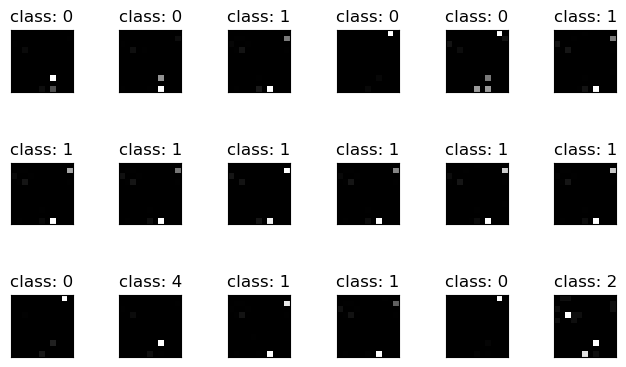

In [96]:
# Visualize the dataset

for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.tight_layout()
    plt.imshow(images_mult_train[i], cmap='gray', interpolation='none')
    plt.title('class: {}'.format(y_train_mult.values[i]))
    plt.yticks([])
    plt.xticks([])

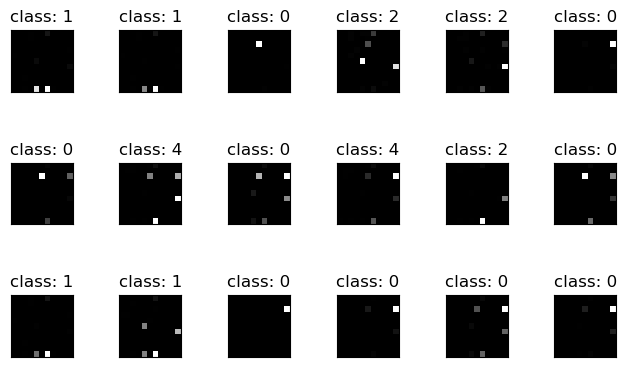

In [97]:
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.tight_layout()
    plt.imshow(images_mult_test[i], cmap='gray', interpolation='none')
    plt.title('class: {}'.format(y_test_mult.values[i]))
    plt.yticks([])
    plt.xticks([])

In [98]:
images_mult_train.shape, images_mult_test.shape

((125973, 11, 11), (22544, 11, 11))

In [99]:
X_train = images_mult_train.reshape(images_mult_train.shape[0], images_mult_train.shape[1],images_mult_train.shape[2], 1)
X_test = images_mult_test.reshape(images_mult_test.shape[0],images_mult_test.shape[1],images_mult_test.shape[2], 1)

In [100]:
X_train.shape, X_test.shape

((125973, 11, 11, 1), (22544, 11, 11, 1))

In [101]:
# reshaping
X_train = X_train/255
X_test = X_test/255

In [105]:
# multi-class classification

model_mult = Sequential()
model_mult.add(Conv2D(32,3,padding='same', input_shape=(11,11,1),activation='relu'))

model_mult.add(Conv2D(64,3,padding='same',activation='relu'))
model_mult.add(MaxPool2D(pool_size=(4)))
model_mult.add(Dropout(0.25))

model_mult.add(Conv2D(128,3,padding='same',activation='relu'))
#model_mult.add(MaxPool2D(pool_size=(4)))
model_mult.add(Dropout(0.25))

model_mult.add(Flatten())
model_mult.add(Dense(256, activation='relu'))
model_mult.add(Dropout(0.5))
model_mult.add(Dense(units=5, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_mult.compile(loss='categorical_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])

model_mult.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,285 (880.02 KB)

 Trainable params: 225,285 (880.02 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

In [107]:
# training the model
history = model_mult.fit(X_train, y_train_mult_b, epochs=50, batch_size=5000,
                         validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.4566 - loss: 5.7498 - val_accuracy: 0.5238 - val_loss: 2.1593
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.5679 - loss: 2.9493 - val_accuracy: 0.7297 - val_loss: 2.6568
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - accuracy: 0.5858 - loss: 2.6425 - val_accuracy: 0.7508 - val_loss: 1.3114
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.6800 - loss: 3.3998 - val_accuracy: 0.8098 - val_loss: 1.1358
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.7738 - loss: 2.0576 - val_accuracy: 0.8204 - val_loss: 1.6937
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.8108 - loss: 1.4182 - val_accuracy: 0.8405 - val_loss: 0.8161
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 399ms/step - accuracy: 0.8355 - loss: 1.8404 - val_accuracy: 0.8410 - val_loss: 0.9972
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 388ms/step - accuracy: 0.8398 - loss: 1.1384 - val_accuracy: 0.

In [ ]:
# training dataset results
#print(f'Training prediction\n Loss: {test_pred[0]}\n Accuracy: {test_pred[1]*100}%')

In [113]:
# predicting target on test data
test_pred = model_mult.evaluate(X_test, y_test_mult_b, verbose=1)
print(f'Test results\n Loss: {test_pred[0]}\n Accuracy: {test_pred[1]*100}%')

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4969 - loss: 4.0779
Test results
 Loss: 4.14993953704834
 Accuracy: 49.68062341213226%


In [114]:
# on test dataset
y_pred = model_mult.predict(X_test, batch_size=500)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [116]:
# print the classification report on the test data

class_names = ['Normal', 'DoS','Probe','U2R','R2L']
y_rounded_pred = np.round(y_pred)

print("Classification Report on Test data\n",
     classification_report(y_test_mult_b, y_rounded_pred, target_names=class_names))

Classification Report on Test data
               precision    recall  f1-score   support

      Normal       0.57      0.95      0.72      9889
         DoS       0.00      0.00      0.00      7460
       Probe       0.00      0.00      0.00      2421
         U2R       0.00      0.00      0.00        67
         R2L       0.00      0.00      0.00      2707

   micro avg       0.54      0.42      0.47     22544
   macro avg       0.11      0.19      0.14     22544
weighted avg       0.25      0.42      0.31     22544
 samples avg       0.42      0.42      0.42     22544



/home/lm/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lm/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


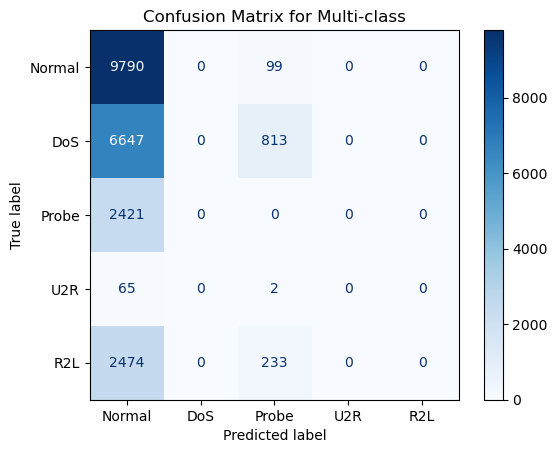

In [118]:
# view the confusion matrix for multi-class classification

cm = confusion_matrix(y_test_mult_b.argmax(axis=1), y_rounded_pred.argmax(axis=1))
cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_fig.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Multi-class')
plt.savefig('confusion_matrix_multi-class.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


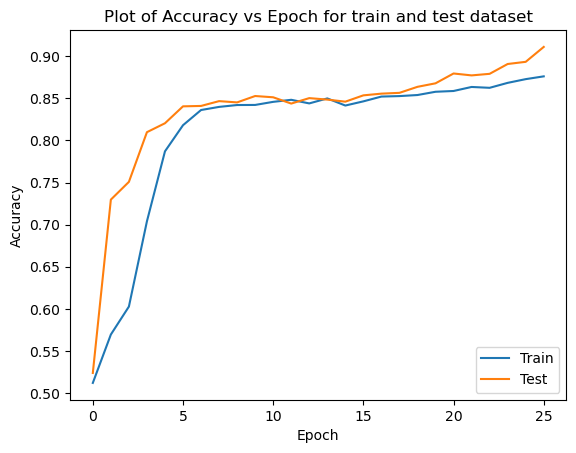

In [119]:
# plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Plot of Accuracy vs Epoch for train and test dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('plot_accuracy_epoch_multiclass.eps')
plt.show()